# EDA(Explanatory Data Analysis) and Stats on the NewYork yellow taxis

<img src = 'https://cabstartup.com/wp-content/uploads/2018/05/Yellow-Taxi-Banner.png' >

## Introduction

- ### The dataset for this project is taken from NYC TLC Trip Record Data. link.
- ### In this project, New york city yellow taxi data of 7 months (Jan - Jul) in year 2021 are taken into consideration for the analysis.
- ### Here Dask, Keplergl, geopandas, pandas, stats library are utilized.

## Objective:

- ### The main goal of this project is to identify maximum taxi usage day, time, payment mode, booking type, ratecodeid
- ### Time difference between pick and drop location.
- ### Top pickup and dropping points in the city
- ### Calculating the mean, median, weighted mean, median absoulte deviation(MAD)
- ### Removing the outliners and checking for the hypothesis condition

## 1. Installing the stats and another libraries

In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd
import os
import glob
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import ticker
from statsmodels import robust
import seaborn as sns

## 2. Loading all files

In [3]:
os.listdir('Trip_data')

['yellow_tripdata_2021-01.csv',
 'yellow_tripdata_2021-02.csv',
 'yellow_tripdata_2021-03.csv',
 'yellow_tripdata_2021-04.csv',
 'yellow_tripdata_2021-05.csv',
 'yellow_tripdata_2021-06.csv',
 'yellow_tripdata_2021-07.csv']

In [4]:
from glob import glob
files_ = sorted(glob(os.path.join('Trip_data', "*csv")))

## 3. Creating the dask dataframe

In [5]:
df = dd.read_csv(files_, parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'], 
                 dtype={'RatecodeID': 'float64', 'VendorID': 'float64',
                     'passenger_count': 'float64', 'payment_type': 'float64', 'tolls_amount': 'float64'})
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2.0,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5
1,1.0,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
2,1.0,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1.0,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0
3,1.0,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1.0,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0
4,2.0,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1.0,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5


In [6]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

## 4. Explaination of the data in the columns

|Field Name   |       Description           |
|---------|----------------------------------|
|VendorID| A code indicating the TPEP provider that provided the record.1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.|
|tpep_pickup_datetime |The date and time when the meter was engaged.|
|tpep_dropoff_datetime |The date and time when the meter was disengaged.|
|Passenger_count |The number of passengers in the vehicle.(This is a driver-entered value.)
|Trip_distance| The elapsed trip distance in miles reported by the taximeter.|
|PULocationID| TLC Taxi Zone in which the taximeter was engaged|
|DOLocationID| TLC Taxi Zone in which the taximeter was disengaged|
|RateCodeID| The final rate code in effect at the end of the trip. (1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester,5=Negotiated fare, 6=Group ride)
|Store_and_fwd_flag| This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.(Y= store and forward trip, N= not a store and forward trip)|
|Payment_type| A numeric code signifying how the passenger paid for the trip. (1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip)|
|Fare_amount| The time-and-distance fare calculated by the meter.|
|Extra| Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.|
|MTA_tax| $0.50 MTA tax that is automatically triggered based on the metered rate in use.
|Improvement_surcharge| $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
|Tip_amount| Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.
|Tolls_amount| Total amount of all tolls paid in trip.|
|Total_amount |The total amount charged to passengers. Does not include cash tips.|

## 5. dtypes in the dataframe

In [7]:
df.compute().info()

D:\Anaconda\envs\my_env\lib\site-packages\dask\dataframe\io\csv.py:125: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  df = pandas_read_text(


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000700 entries, 0 to 290639
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               float64       
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
dtypes: datetime64[ns](2), 

In [8]:
df.compute().shape

D:\Anaconda\envs\my_env\lib\site-packages\dask\dataframe\io\csv.py:125: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  df = pandas_read_text(


(15000700, 18)

In [9]:
# no. of missing values in the columns
df.isnull().sum().compute()

D:\Anaconda\envs\my_env\lib\site-packages\dask\dataframe\io\csv.py:125: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  df = pandas_read_text(


VendorID                 834028
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          834028
trip_distance                 0
RatecodeID               834028
store_and_fwd_flag       834028
PULocationID                  0
DOLocationID                  0
payment_type             834028
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge          0
dtype: int64

## 6. creating a sample data frame

In [10]:
#creating the sample with fraction 
new_data = df.sample(frac= 0.04).persist()

D:\Anaconda\envs\my_env\lib\site-packages\dask\dataframe\io\csv.py:125: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  df = pandas_read_text(


In [11]:
new_data.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600027 entries, 156082 to 212100
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               566450 non-null  float64       
 1   tpep_pickup_datetime   600027 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  600027 non-null  datetime64[ns]
 3   passenger_count        566450 non-null  float64       
 4   trip_distance          600027 non-null  float64       
 5   RatecodeID             566450 non-null  float64       
 6   store_and_fwd_flag     566450 non-null  object        
 7   PULocationID           600027 non-null  int64         
 8   DOLocationID           600027 non-null  int64         
 9   payment_type           566450 non-null  float64       
 10  fare_amount            600027 non-null  float64       
 11  extra                  600027 non-null  float64       
 12  mta_tax                600027 non-null 

In [12]:
new_dt = new_data.compute().reset_index()

In [13]:
new_dt.isnull().sum()

index                        0
VendorID                 33577
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          33577
trip_distance                0
RatecodeID               33577
store_and_fwd_flag       33577
PULocationID                 0
DOLocationID                 0
payment_type             33577
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge         0
dtype: int64

In [14]:
# dropping the values
new_dt.drop('index', axis=1, inplace= True)

## 7. Dropping duplicates and NaN values

In [15]:
new_dt.drop_duplicates(inplace= True)

In [16]:
new_dt.shape

(600027, 18)

In [17]:
new_dt.dropna(inplace = True)

In [18]:
# reseting the index
new_dt.reset_index(drop = True, inplace = True)

In [19]:
new_dt['tpep_pickup_datetime'][1]

Timestamp('2021-01-08 22:46:57')

## 8. Calculating the time difference

In [20]:
#time difference function
def time_(x):
    y = round((new_dt['tpep_dropoff_datetime'][x] - new_dt['tpep_pickup_datetime'][x])/np.timedelta64(1, 'm'), 2)
    return y
time_(0)

6.58

In [21]:
#appending difference time to list
t1 = []
for i in range(len(new_dt)):
    t = time_(i)
    t1.append(t)

In [22]:
# adding a new column with time diff
new_dt['Time_diff_min'] = t1

## 9. Calculating the longitude and latitude

In [23]:
# converting into the list
pick_up_location = list(new_dt['PULocationID'].astype(str))

### 9.1. Adding 'NY' above the pickup and drop ID

In [24]:
pick_up_point = []
for i in pick_up_location:
    x_ = 'NY' + ' ' + i
    pick_up_point.append(x_)

In [25]:
new_dt['Pick_locationId'] = pick_up_point
pick_loc = list(new_dt['Pick_locationId'])

In [26]:
drop_off_location = list(new_dt['DOLocationID'].astype(str))

In [27]:
# concatenating the 'NY' (Newyork) and the string for easy identification of location
drop_off_point = []
for i in drop_off_location:
    x_ = 'NY' + ' ' + i
    drop_off_point.append(x_)

In [28]:
# creating a new column with concatenate values
new_dt['dropoff_locationId'] = drop_off_point
drop_loc = list(new_dt['dropoff_locationId'])

In [29]:
from dask import delayed

In [30]:
@delayed(pure = True)
def addr_long(x):
    from geopy.geocoders import ArcGIS
    lat_ = []
    long_ = []
    points = []
    for i in x:
        loc = ArcGIS()
        addr = loc.geocode(i, timeout=None)
        if addr is None:
            lat_.append(None)
            long_.append(None)
        else:
            longitude = addr.longitude
            latitude = addr.latitude
            points.append((longitude, latitude))
    return points
addr_long(['NY 151']).compute()

[(-73.98560299999997, 40.719130000000064)]

In [31]:
%%time
# calculating the pickup location
plocation = [] 
for i in pick_loc[0:len(pick_loc)]:
    x = addr_long([i])
    plocation.append(x)

Wall time: 25.5 s


In [32]:
%%time
# calculating the dropoff location
dlocation = [] 
for i in drop_loc[0:len(drop_loc)]:
    d_ = addr_long([i])
    dlocation.append(d_)

Wall time: 22.7 s


In [33]:
# dask.compute() is used to show the results and it saves a lot of time

pickup_loc = dask.compute(plocation)

In [34]:
dropoff_loc = dask.compute(dlocation)

In [35]:
#extracting the location and adding
new_dt['pi_location'] = pickup_loc[0]

In [36]:
# creating list with all pickup locations
p_location = []
for i in range(len(new_dt['pi_location'])):
    x2 = new_dt['pi_location'][i][0]
    p_location.append(x2)

In [37]:
# reassigning to the initial column
new_dt['pi_location'] = p_location

In [38]:
#extracting the location and adding
new_dt['drop_location'] = dropoff_loc[0]

In [39]:
# creating list with all dropoff locations
dr_location = []
for i in range(len(new_dt['drop_location'])):
    x3 = new_dt['drop_location'][i][0]
    dr_location.append(x3)

In [40]:
# reassigning to the initial column
new_dt['drop_location'] = dr_location

In [41]:
new_dt['pick_day'] = new_dt['tpep_pickup_datetime'].dt.day_name()
new_dt['dropping_day'] = new_dt['tpep_dropoff_datetime'].dt.day_name()

In [42]:
new_dt.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,Time_diff_min,Pick_locationId,dropoff_locationId,pi_location,drop_location,pick_day,dropping_day
0,1.0,2021-01-05 18:50:35,2021-01-05 18:57:10,1.0,1.10,1.0,N,79,144,1.0,...,0.3,12.95,2.5,6.58,NY 79,NY 144,"(-78.34029361099994, 42.596728333000044)","(-73.81040921589874, 40.701235218364886)",Tuesday,Tuesday
1,2.0,2021-01-08 22:46:57,2021-01-08 23:01:22,1.0,3.95,1.0,N,231,181,1.0,...,0.3,22.56,2.5,14.42,NY 231,NY 181,"(-73.73123662051584, 40.690845650429516)","(-73.78058075774179, 40.71052242474511)",Friday,Friday
2,2.0,2021-01-01 19:39:47,2021-01-01 19:49:50,1.0,1.93,1.0,N,79,45,1.0,...,0.3,12.30,2.5,10.05,NY 79,NY 45,"(-78.34029361099994, 42.596728333000044)","(-73.95557999999994, 41.09789000000006)",Friday,Friday
3,1.0,2021-01-05 17:19:22,2021-01-05 17:25:42,1.0,1.20,1.0,N,75,238,1.0,...,0.3,9.95,0.0,6.33,NY 75,NY 238,"(-73.48961111099999, 40.80469444400006)","(-73.72440237183947, 40.69231477225274)",Tuesday,Tuesday
4,1.0,2021-01-07 18:59:33,2021-01-07 19:00:24,1.0,0.00,5.0,N,164,164,1.0,...,0.3,11.30,0.0,0.85,NY 164,NY 164,"(-73.80297832398533, 40.750415354616045)","(-73.80297832398533, 40.750415354616045)",Thursday,Thursday


## 10. Data visualiaztion

### 10.1. Weekday Vs Distance

Text(0.5, 1.0, 'Weekday vs Distance')

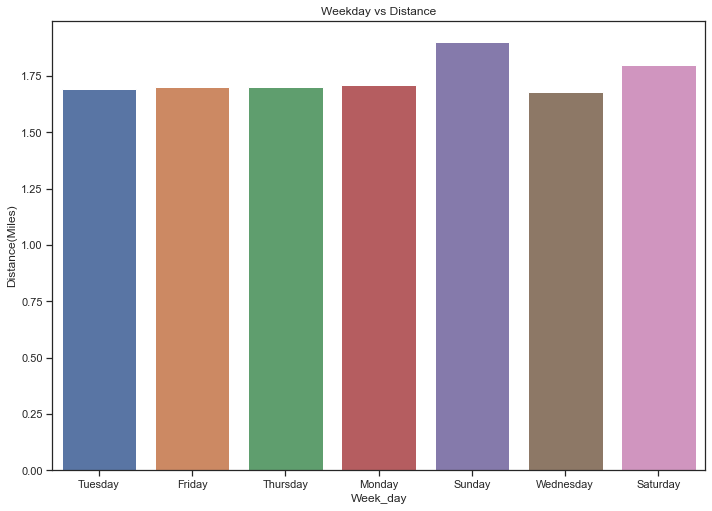

In [43]:
from numpy import median
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.barplot(data= new_dt, x = 'pick_day', y='trip_distance', estimator= median, ci= None)
ax.set(xlabel='Week_day', ylabel='Distance(Miles)')
ax.set_title('Weekday vs Distance')

### 10.2. Weekday Vs Passenger_count

[Text(0.5, 0, 'Weekday'), Text(0, 0.5, 'Passenger_count')]

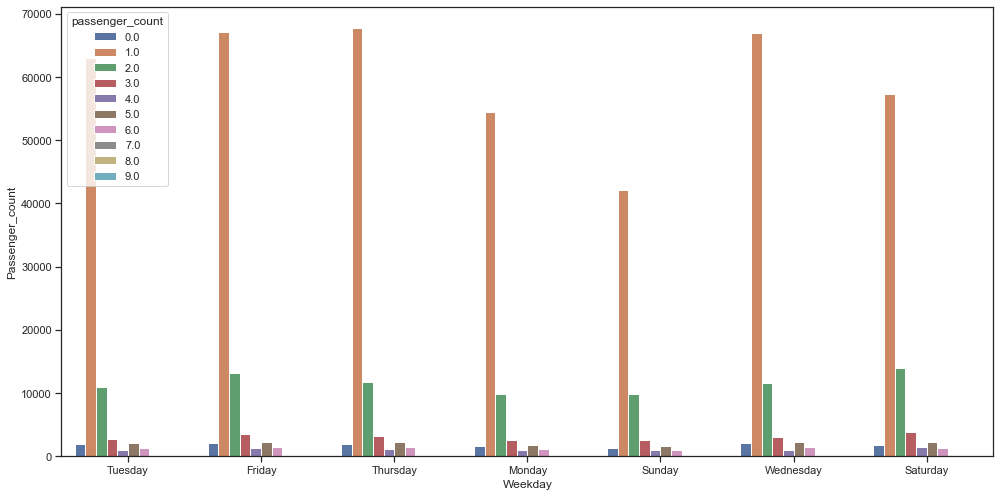

In [44]:
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax = sns.countplot(x="pick_day", hue="passenger_count", data=new_dt)
sns.color_palette('dark')
ax.set(xlabel='Weekday', ylabel='Passenger_count')

### 10.3. Time Vs Passenger_count

Text(0.5, 1.0, 'Time Vs Passenger counts')

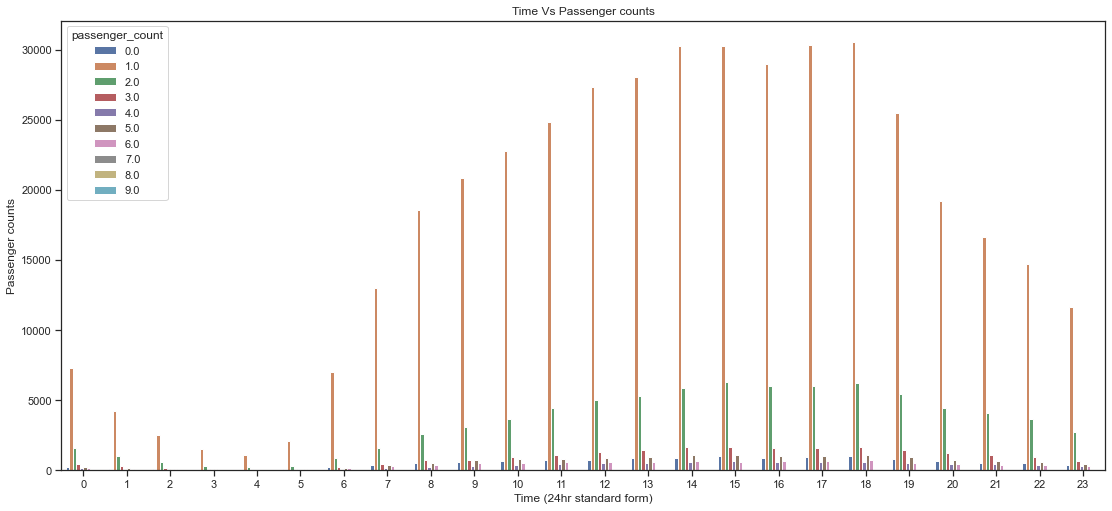

In [45]:
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(18.7, 8.27)
ax = sns.countplot(data= new_dt, hue="passenger_count", x= new_dt['tpep_pickup_datetime'].dt.hour)
ax.set(xlabel='Time (24hr standard form)', ylabel='Passenger counts')
ax.set_title('Time Vs Passenger counts')

### 10.4. VendorId Vs Passenger_count

Text(0.5, 1.0, 'VendorID Vs Passenger counts')

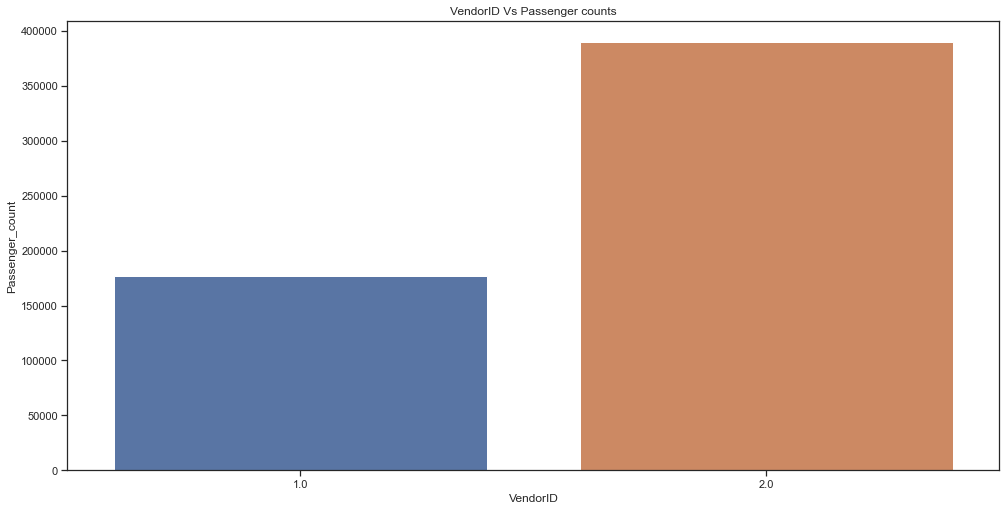

In [46]:
#1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax = sns.countplot(x="VendorID", data=new_dt)
sns.color_palette('dark')
ax.set(xlabel='VendorID', ylabel='Passenger_count')
ax.set_title('VendorID Vs Passenger counts')

### 10.5. VendorId Vs Passenger_count on the weekdays

Text(0.5, 1.0, 'VendorID Vs Passenger counts')

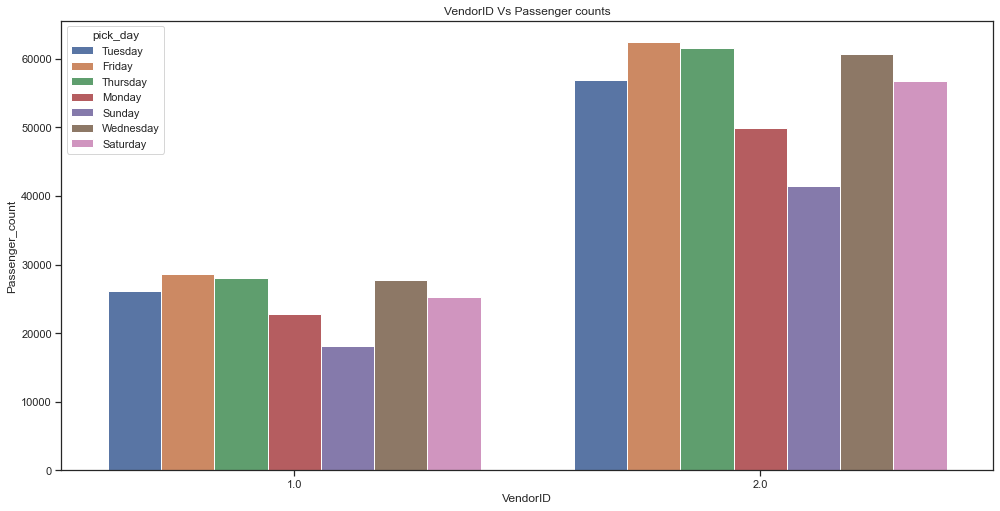

In [47]:
#1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax = sns.countplot(x="VendorID", data=new_dt, hue = 'pick_day')
sns.color_palette('dark')
ax.set(xlabel='VendorID', ylabel='Passenger_count')
ax.set_title('VendorID Vs Passenger counts')

### 10.6. RatecodeID Vs Passenger count

Text(0.5, 1.0, 'RatecodeID Vs Passenger counts')

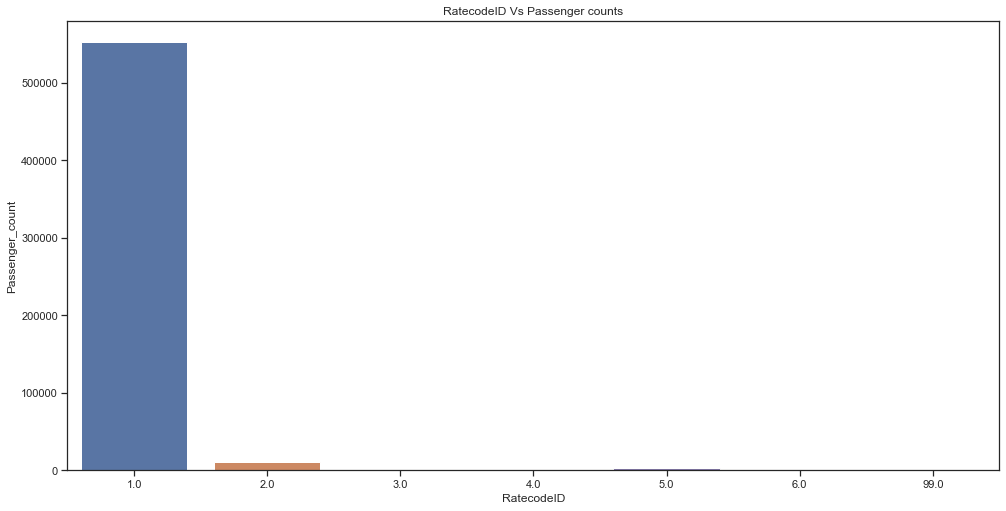

In [48]:
#(1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester,5=Negotiated fare, 6=Group ride)
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax = sns.countplot(x="RatecodeID", data=new_dt)
sns.color_palette('dark')
ax.set(xlabel='RatecodeID', ylabel='Passenger_count')
ax.set_title('RatecodeID Vs Passenger counts')

### 10.7. Payment Mode Vs Passenger Count

Text(0.5, 1.0, 'Payment_mode Vs Passenger counts')

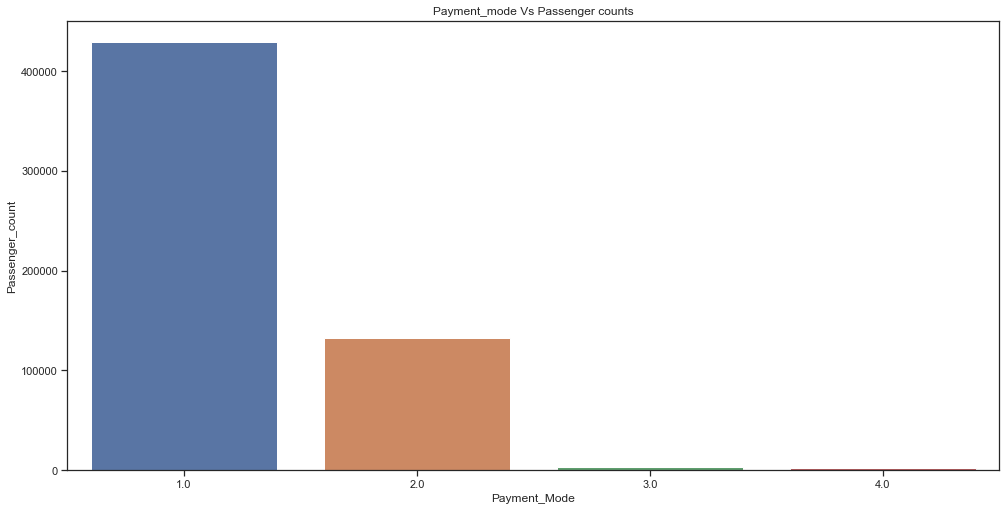

In [49]:
#(1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip)
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax = sns.countplot(x="payment_type", data=new_dt)
sns.color_palette('dark')
ax.set(xlabel='Payment_Mode', ylabel='Passenger_count')
ax.set_title('Payment_mode Vs Passenger counts')

### 10.8. Payment Mode Vs Passenger counts on the weekday

Text(0.5, 1.0, 'Payment_mode Vs Passenger counts')

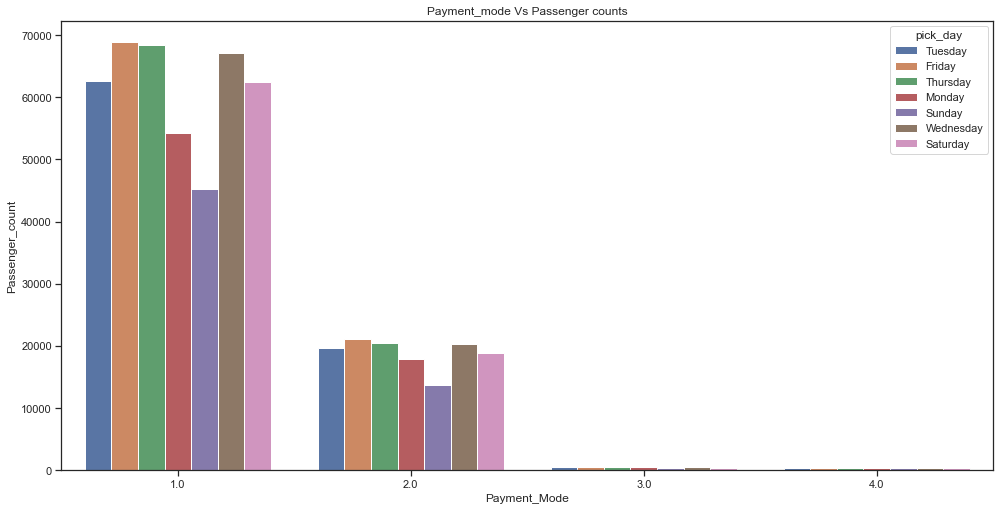

In [50]:
#(1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip)
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax = sns.countplot(x="payment_type", data=new_dt, hue = 'pick_day')
sns.color_palette('dark')
ax.set(xlabel='Payment_Mode', ylabel='Passenger_count')
ax.set_title('Payment_mode Vs Passenger counts')

### 10.9. Highest amount on the days

Text(0.5, 1.0, 'Weekday Vs Total_amount')

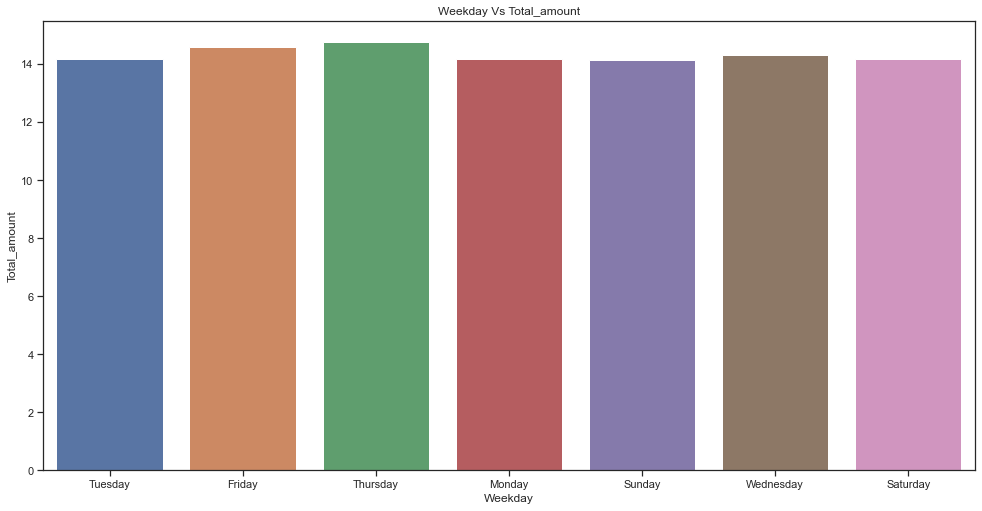

In [51]:
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(16.7, 8.27)
ax = sns.barplot(data = new_dt, x= 'pick_day', y="total_amount", estimator= median, ci = None)
sns.color_palette('dark')
ax.set(xlabel='Weekday', ylabel='Total_amount')
ax.set_title('Weekday Vs Total_amount')

### 10.10. Top 10 Pickup location

Text(0.5, 1.0, 'Top Pickup Locations')

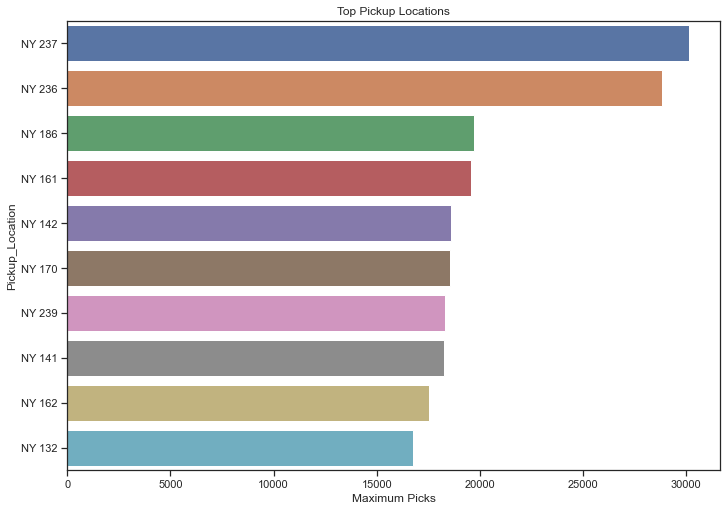

In [52]:
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(data=new_dt, order=new_dt.Pick_locationId.value_counts().nlargest(10).index, y='Pick_locationId')
ax.set(xlabel='Maximum Picks', ylabel='Pickup_Location')
ax.set_title('Top Pickup Locations')

### 10.11. Top 10 Drop off location

Text(0.5, 1.0, 'Top Dropoff Locations')

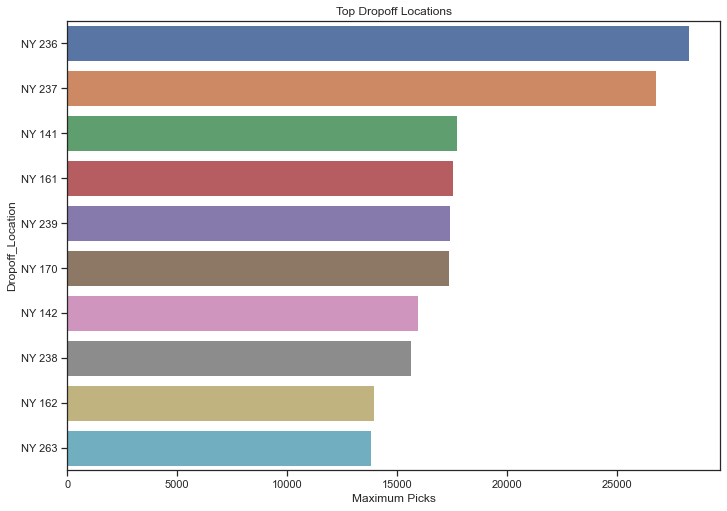

In [53]:
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(data=new_dt, order=new_dt.dropoff_locationId.value_counts().nlargest(10).index, y='dropoff_locationId')
ax.set(xlabel='Maximum Picks', ylabel='Dropoff_Location')
ax.set_title('Top Dropoff Locations')

### 10.12. Interactive map visualization of pickup and drop off location

In [54]:
s_coordinates = []
for i in range(len(new_dt)):
    x = list(new_dt['pi_location'][i])
    s_coordinates.append(x)

In [55]:
d_coordinates = []
for i in range(len(new_dt)):
    x1 = list(new_dt['drop_location'][i])
    d_coordinates.append(x1)

In [56]:
new_dt['s_coordinates'] = s_coordinates
new_dt['d_coordinates'] = d_coordinates

### 10.12.1. Installing the keplergl for visualization

In [57]:
from keplergl import KeplerGl
import geopandas as gpd

In [58]:
new_dt.drop(['s_coordinates', 'd_coordinates'], axis =1, inplace = True)

In [59]:
# creating a 4 new columns for starting and ending latitudes and longtitudes

new_dt[['slat', 'slong']] = pd.DataFrame(new_dt['pi_location'].tolist(), index=new_dt.index)
new_dt[['elat', 'elong']] = pd.DataFrame(new_dt['drop_location'].tolist(), index=new_dt.index)

In [60]:
new_dt.columns = ['VendorID', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Time_diff_min',
       'Pick_locationId', 'dropoff_locationId', 'pi_location', 'drop_location',
       'pick_day', 'dropping_day', 'slong', 'slat', 'elong', 'elat']

In [61]:
gdf = gpd.GeoDataFrame(new_dt, geometry= gpd.points_from_xy(new_dt.slong, new_dt.slat))

In [62]:
map_1 = KeplerGl()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [63]:
map_1.add_data(data = gdf, name = "pickup_location")

### 10.12.2. All pickup locations

In [64]:
map_1

KeplerGl(data={'pickup_location': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

In [65]:
gdf1 = gpd.GeoDataFrame(new_dt, geometry= gpd.points_from_xy(new_dt.elong, new_dt.elat))

In [66]:
map_2 = KeplerGl()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [67]:
map_2.add_data(data = gdf1, name = "drop_location")

### 10.12.3. All Dropoff locations

In [68]:
map_2

KeplerGl(data={'drop_location': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

## 11. Stats data

In [69]:
# descriptive stats

new_dt.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Time_diff_min,slong,slat,elong,elat
count,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000,566450.000000
mean,1.688216,1.425453,2.862096,1.046313,165.840134,163.661808,1.256838,12.087410,1.034122,0.492591,2.185382,0.271753,0.296884,17.963892,2.274389,15.262631,-73.679074,41.031823,-73.958366,41.156408
std,0.463223,1.044745,4.290788,0.790335,66.149308,70.773446,0.476815,11.174848,1.236606,0.077945,2.554460,1.415896,0.042596,13.519150,0.750687,60.642483,8.479891,2.377528,4.023839,1.337627
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-631.000000,-4.500000,-0.500000,-58.000000,-38.020000,-0.300000,-634.800000,-2.500000,0.000000,-79.440601,-6.922270,-79.440601,-6.922270
25%,1.000000,1.000000,1.030000,1.000000,132.000000,113.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,11.160000,2.500000,6.200000,-73.810409,40.692853,-73.807817,40.692853
50%,2.000000,1.000000,1.710000,1.000000,162.000000,162.000000,1.000000,9.000000,0.500000,0.500000,2.000000,0.000000,0.300000,14.300000,2.500000,10.050000,-73.793568,40.723257,-73.780581,40.731600
75%,2.000000,1.000000,3.000000,1.000000,236.000000,236.000000,1.000000,13.500000,2.500000,0.500000,2.950000,0.000000,0.300000,19.550000,2.500000,15.920000,-73.725336,40.777740,-73.725336,40.804694
max,2.000000,9.000000,900.000000,99.000000,265.000000,265.000000,4.000000,684.070000,8.250000,0.500000,200.000000,70.000000,0.300000,684.070000,2.500000,1439.900000,107.605730,59.913175,107.605730,59.913175


In [70]:
# for catgeorical

new_dt.describe(include = 'object')

,store_and_fwd_flag,Pick_locationId,dropoff_locationId,pi_location,drop_location,pick_day,dropping_day,geometry
count,566450,566450,566450,566450,566450,566450,566450,566450
unique,2,249,259,249,259,7,7,259
top,N,NY 237,NY 236,"(-73.72533553048825, 40.69285268505702)","(-73.72856419950617, 40.686307804971754)",Friday,Friday,POINT (-73.7285641995061667 40.6863078049717544)
freq,559892,30143,28267,30143,28267,91027,90782,28267


### 11.1. Checking for the outliners

Text(0, 0.5, 'Time')

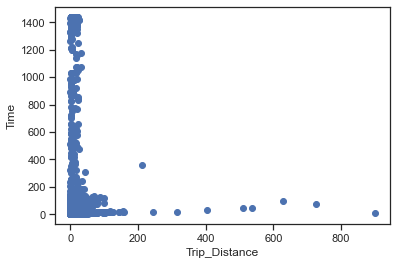

In [77]:
# Trip_distance Vs Time_diff_min

plt.scatter(new_dt["trip_distance"], new_dt["Time_diff_min"])
plt.xlabel('Trip_Distance')
plt.ylabel('Time')

Text(0, 0.5, 'Amount')

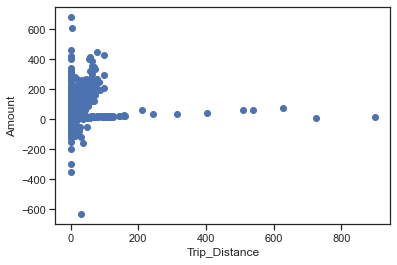

In [78]:
# Trip_distance Vs Total_amount

plt.scatter(new_dt["trip_distance"], new_dt["total_amount"])
plt.xlabel('Trip_Distance')
plt.ylabel('Amount')

Text(0.5, 0, 'Passenger_count')

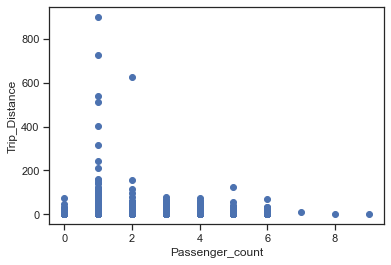

In [79]:
# Passenger count Vs Trip_distance

plt.scatter(new_dt["passenger_count"], new_dt["trip_distance"])
plt.ylabel('Trip_Distance')
plt.xlabel('Passenger_count')

## 12. Observing the outliners in the data

<AxesSubplot:>

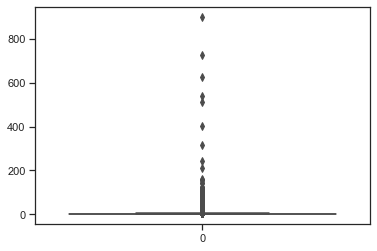

In [80]:
# outliners in the trip_distance

sns.boxplot(data = new_dt['trip_distance'])

<AxesSubplot:>

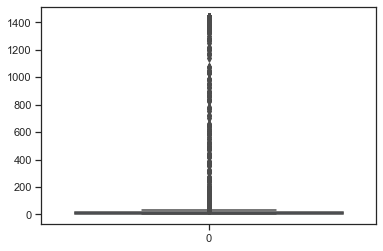

In [82]:
# outliners in the time_diff_min

sns.boxplot(data = new_dt['Time_diff_min'])

## 13. Studying with trip_distance

In [87]:
new_dt[new_dt.trip_distance == new_dt.trip_distance.max()]

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,dropoff_locationId,pi_location,drop_location,pick_day,dropping_day,slong,slat,elong,elat,geometry
81853,1.0,2021-02-17 20:52:46,2021-02-17 20:59:16,1.0,900.0,1.0,N,142,238,1.0,...,NY 238,"(-73.80514812375264, 40.68788662636029)","(-73.72440237183947, 40.69231477225274)",Wednesday,Wednesday,-73.805148,40.687887,-73.724402,40.692315,POINT (-73.7244023718394743 40.6923147722527432)


<AxesSubplot:>

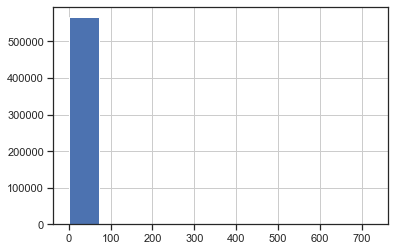

In [88]:
new_dt[new_dt.trip_distance < 900]['trip_distance'].hist()

In [94]:
new_dt.trip_distance.nlargest(10)

81853     900.00
195980    726.61
249828    627.20
271373    538.10
458179    509.80
409698    402.90
501575    315.10
357216    243.60
348097    211.24
356988    159.90
Name: trip_distance, dtype: float64

<AxesSubplot:>

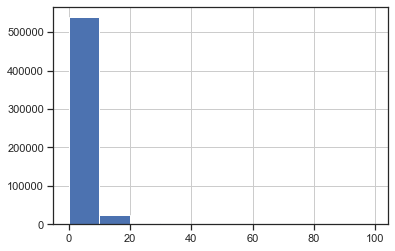

In [101]:
new_dt[new_dt.trip_distance < 100]['trip_distance'].hist()

## 14. Creating the new data frame

In [109]:
anays = new_dt.loc[:,['trip_distance', 'passenger_count', 'Time_diff_min']]
anays.head()


,trip_distance,passenger_count,Time_diff_min
0,1.10,1.0,6.58
1,3.95,1.0,14.42
2,1.93,1.0,10.05
3,1.20,1.0,6.33
4,0.00,1.0,0.85


In [112]:
anays[anays.trip_distance == anays.trip_distance.max()]

,trip_distance,passenger_count,Time_diff_min
81853,900.0,1.0,6.5


 $$ Time = Distance / Speed $$

- As per the above formula we can assume driver is travelled at speed of 138.46 M/min. Which is highly impossible in the Newyork city streets
- World's fastest car speed is 330 MPH (Koenigsegg Jesko Absolut)
- 1 mile = 1.60 km 

<AxesSubplot:>

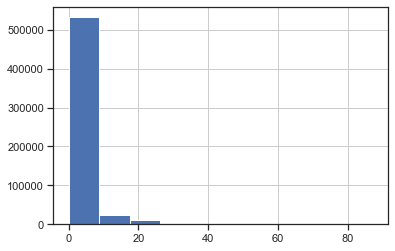

In [115]:
anays[anays.trip_distance < 90]['trip_distance'].hist()

## 15. Calculating the mean, median, mode

### 15.1. Mean, median, trimmed mean

In [117]:
print(f"original mean----> {anays.trip_distance.mean()}")
print(f"median----> {anays.trip_distance.median()}")

# trimmed mean
print(f"trimmed mean----> {stats.trim_mean(anays.trip_distance, proportiontocut = 0.3)}")

original mean----> 2.8620963897961493
median----> 1.71
trimmed mean----> 1.7765676140877393


### 15.2.  Weighted mean

In [118]:
print(f' weighted mean---->{np.average(anays.trip_distance,weights=anays["passenger_count"])}')

 weighted mean---->2.9183724153134327


### 15.3.  Weighted median

In [119]:
!pip install wquantiles

  Using cached wquantiles-0.6-py3-none-any.whl (3.3 kB)


In [120]:
import weighted

In [121]:
weighted.median(anays.trip_distance,weights=anays["passenger_count"])

1.74

In [122]:
anays.trip_distance.median()

1.71

### 15.4. Estimating the variability

In [124]:
print(f"std ----> {anays.trip_distance.std()}")
print(f"variance -----> {anays.trip_distance.var()}")

std ----> 4.290788288984629
variance -----> 18.410864140887643


### 15.5. MAD((median absoulte deviation from median))

In [125]:
stats.median_abs_deviation(anays.trip_distance, scale= 1/1.4826) #1.4826 check wiki

1.2157319999999998

### 15.6. IQR - inter quantile range

In [126]:
q3 = anays.trip_distance.quantile(0.75)
q1 = anays.trip_distance.quantile(0.25)
IQR = q3 - q1
IQR

1.97

<AxesSubplot:>

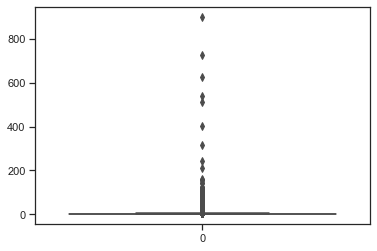

In [127]:
# data with outliners 

sns.boxplot(data = anays.trip_distance)

### 15.7. whiskers in the data

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fhelp.ezbiocloud.net%2Fwp%2Fwp-content%2Fuploads%2F2018%2F03%2FA-typical-box-plot.png&f=1&nofb=1">

In [128]:
# whiskers
lower_whis = q1 - (1.5*IQR)
upper_whis = q3 + (1.5*IQR)

In [129]:
lower_whis, upper_whis

(-1.925, 5.955)

### 15.8. data without outliners

In [130]:
# data without outliner 

data_without_outliner = anays[(anays.trip_distance > lower_whis) & (anays.trip_distance < upper_whis)]

In [131]:
data_without_outliner.head()

,trip_distance,passenger_count,Time_diff_min
0,1.10,1.0,6.58
1,3.95,1.0,14.42
2,1.93,1.0,10.05
3,1.20,1.0,6.33
4,0.00,1.0,0.85


<AxesSubplot:>

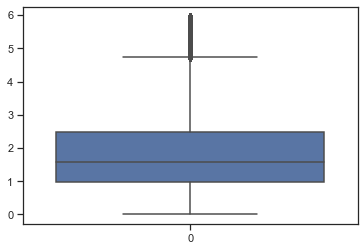

In [132]:
sns.boxplot(data = data_without_outliner.trip_distance)

Text(0, 0.5, 'Time')

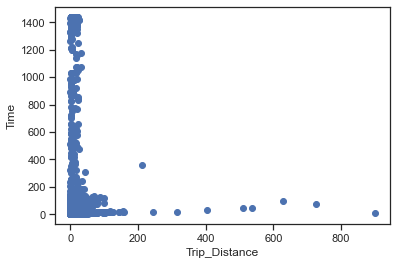

In [133]:
plt.scatter(new_dt["trip_distance"], new_dt["Time_diff_min"])
plt.xlabel('Trip_Distance')
plt.ylabel('Time')

Text(0, 0.5, 'Time')

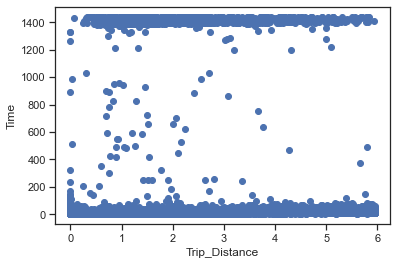

In [134]:
plt.scatter(data_without_outliner["trip_distance"], data_without_outliner["Time_diff_min"])
plt.xlabel('Trip_Distance')
plt.ylabel('Time')

## 16. Studying the outliners in time difference

### 16.1. Calculating the mean, median, and trimmed mean

In [136]:
data_without_outliner.Time_diff_min.max()

1439.9

In [137]:
print(f"original mean----> {data_without_outliner.Time_diff_min.mean()}")
print(f"median----> {data_without_outliner.Time_diff_min.median()}")

# trimmed mean
print(f"trimmed mean----> {stats.trim_mean(data_without_outliner.Time_diff_min, proportiontocut = 0.3)}")

original mean----> 12.92916869381273
median----> 9.22
trimmed mean----> 9.331266133928745


### 16.2. Weighted median

In [141]:
weighted.median(data_without_outliner.Time_diff_min,weights=data_without_outliner["passenger_count"])

9.25

In [140]:
data_without_outliner['Time_diff_min'].median()

9.22

### 16.3. Standard deviation and variance

In [143]:
print(f"std ----> {data_without_outliner.Time_diff_min.std()}")
print(f"variance -----> {data_without_outliner.Time_diff_min.var()}")

std ----> 57.78467032149552
variance -----> 3339.068124163925


In [144]:
stats.median_abs_deviation(data_without_outliner.Time_diff_min, scale= 1/1.4826) #1.4826 check wiki

5.648705999999998

### 16.4. Whiskers in the data

In [145]:
q7 = data_without_outliner.Time_diff_min.quantile(0.75)
q5 = data_without_outliner.Time_diff_min.quantile(0.25)
IQR_ = q7 - q5
IQR_

7.950000000000001

In [146]:
# whiskers
lower_whis_ = q5 - (1.5*IQR_)
upper_whis_ = q7 + (1.5*IQR_)

In [147]:
lower_whis_, upper_whis_

(-6.075000000000001, 25.725)

### 16.5. Removing the outliners from the data

In [158]:
# without outliner data
new_data = data_without_outliner[(data_without_outliner.Time_diff_min > lower_whis) & (data_without_outliner.Time_diff_min < upper_whis)]

In [159]:
new_data.reset_index(drop = True, inplace= True)

In [161]:
new_data.head()

,trip_distance,passenger_count,Time_diff_min
0,0.00,1.0,0.85
1,0.95,2.0,3.10
2,0.47,5.0,1.92
3,0.62,5.0,4.70
4,0.87,1.0,5.52


<AxesSubplot:>

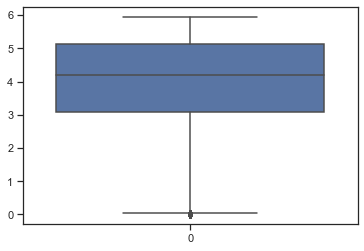

In [162]:
# modified one
sns.boxplot(data = new_data.Time_diff_min)

<AxesSubplot:>

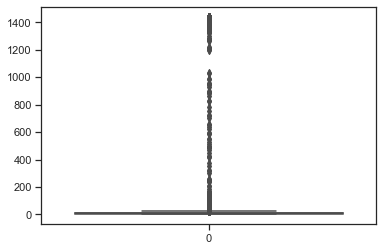

In [163]:
# original one
sns.boxplot(data = data_without_outliner.Time_diff_min)

Text(0, 0.5, 'Time')

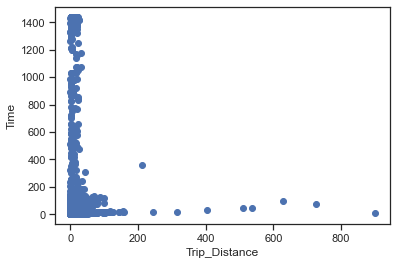

In [164]:
# original one with all outliner
plt.scatter(new_dt["trip_distance"], new_dt["Time_diff_min"])
plt.xlabel('Trip_Distance')
plt.ylabel('Time')

Text(0, 0.5, 'Time')

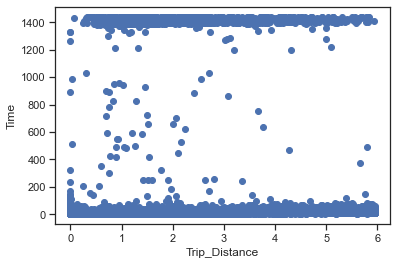

In [165]:
# after removing outliner in trip_distance
plt.scatter(data_without_outliner["trip_distance"], data_without_outliner["Time_diff_min"])
plt.xlabel('Trip_Distance')
plt.ylabel('Time')

Text(0, 0.5, 'Time')

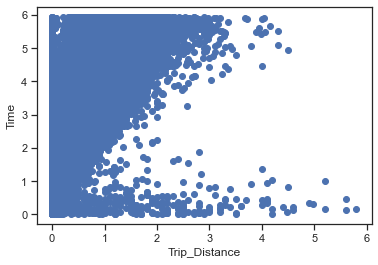

In [166]:
# after removing outliner in trip_distance, time
plt.scatter(new_data["trip_distance"], new_data["Time_diff_min"])
plt.xlabel('Trip_Distance')
plt.ylabel('Time')

## 17. Correlation

In [167]:
anays.corr()

,trip_distance,passenger_count,Time_diff_min
trip_distance,1.000000,0.017895,0.122056
passenger_count,0.017895,1.000000,0.015858
Time_diff_min,0.122056,0.015858,1.000000


In [168]:
data_without_outliner.corr()

,trip_distance,passenger_count,Time_diff_min
trip_distance,1.000000,0.020549,0.095560
passenger_count,0.020549,1.000000,0.013074
Time_diff_min,0.095560,0.013074,1.000000


In [169]:
new_data.corr()

,trip_distance,passenger_count,Time_diff_min
trip_distance,1.000000,0.024880,0.620121
passenger_count,0.024880,1.000000,0.019996
Time_diff_min,0.620121,0.019996,1.000000


## 18. Significance testing and testing the hypothesis

### 18.1. Creating the cross tab

In [181]:
# create contingency table
data_crosstab = pd.crosstab(new_data['trip_distance'],
                            new_data['Time_diff_min'],
                           margins=True, margins_name="Total")

# significance level
alpha = 0.05

# Calcualtion of Chisquare test statistics
chi_square = 0
rows = new_data['trip_distance'].unique()
columns = new_data['Time_diff_min'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

In [182]:
data_crosstab

Time_diff_min,0.0,0.02,0.03,0.05,0.07,0.08,0.1,0.12,0.13,0.15,...,5.82,5.83,5.85,5.87,5.88,5.9,5.92,5.93,5.95,Total
trip_distance,,,,,,,,,,,,,,,,,,,,,
0.0,395,23,124,188,190,197,155,144,170,142,...,1,0,2,2,0,1,1,2,2,4321
0.01,3,1,8,12,16,11,13,19,21,16,...,0,0,0,0,0,0,0,0,0,308
0.02,0,0,0,7,9,13,9,11,13,10,...,0,0,0,0,0,0,0,0,0,275
0.03,0,0,3,5,5,9,4,8,8,8,...,0,0,0,0,0,0,0,0,0,207
0.04,0,0,2,5,4,3,1,0,5,1,...,0,0,0,0,0,0,0,0,0,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
5.6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2


In [177]:
chi_square

5881035.938635084

In [183]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(data_crosstab.values)

In [184]:
print("Chi-square value:", stat)
print("Degree of freedom:", dof)

Chi-square value: 307913.4017603069
Degree of freedom: 119930


### 18.2. Testing the hypothesis

In [173]:
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)

Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 307913.4017603122  and p value is: 0.0
Null Hypothesis is rejected.


In [174]:
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
print(conclusion)


--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 307913.4017603122  and critical value is: 120042.38331569826
Null Hypothesis is rejected.


In [185]:
X = new_data.trip_distance
y = new_data.Time_diff_min

In [189]:
import statsmodels.api as sm
model = sm.OLS(y, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Time_diff_min   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                          9.605e+05
Date:                Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                        14:40:16   Log-Likelihood:                     -2.3813e+05
No. Observations:              132217   AIC:                                  4.763e+05
Df Residuals:                  132216   BIC:                                  4.763e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
trip_distance     4.4640      0.005    980.058      0.000       4.455       4.473
==============================================================================
Omnibus:                    57998.317   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1206540.695
Skew:                          -1.616   Prob(JB):                         0.00
Kurtosis:                      17.442   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 18.3. Final overview of the all ditributions

In [195]:
%pip install pandas_profiling

  Using cached pandas_profiling-3.1.0-py2.py3-none-any.whl (261 kB)
  Using cached tangled_up_in_unicode-0.1.0-py3-none-any.whl (3.1 MB)
  Using cached multimethod-1.6-py3-none-any.whl (9.4 kB)
  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)

  Using cached htmlmin-0.1.12.tar.gz (19 kB)
  Using cached visions-0.7.4-py3-none-any.whl (102 kB)
  Using cached ImageHash-4.2.1.tar.gz (812 kB)
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=43a319d8552a0c9ebf0ab76557ed6fe777fe470572f5c47a23c6c7eaa0072088
  Stored in directory: c:\users\nikhi\appdata\local\pip\cache\wheels\1d\05\04\c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=83809aa7cd779c84135dab91a129e548598cd7992fab16d9a556d61a726ce28c
  Stored in directory: c:\users\nikhi\appdata\local\pip\cache\wheels\51\f9\a5\740af2fdb0ad1edf79aabdc41531be0b6f0b2e2be684c388cf
Successfully built htmlmin im

In [196]:
from pandas_profiling import ProfileReport
ProfileReport(new_data)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


## Conclusion

### In this dataset, the latitude, longitude, time difference are calculated. Few outliners are also identified in the data due to improper entry and performed statistical analysis

### From the calculations and analysis following are key findings:

- ### Friday is the most active day and where most people utilized the taxis.
- ### Raids with a single passenger are booked more compared to the 2,3,4 passengers
- ### NY 237 is the most common pickup point. Because it has an intersection with famous locations and schools.
- ### NY 236 is the most common dropoff point. 
- ### Where NY 140 has low pickup points and NY 99 has low dropping points compared to all others.
- ### Wednesday and thursday are the most busiest days at NY 236 location
- ### From morning 6 am to 14 pm is linear increment and from 15 pm to night 23 pm there is linear decrement
- ### From Night 1 am to 5 am usage of taxis are very low.
- ### All taxis following the standard rate for the trips and most commonly used payment mode is 'credit card'
- ### 'VeriFone Inc' has more number of booking compared to the 'Creative Mobile Technologies'
- ### There is a positive correlation between the time, distance, passenger counts
- ### There is relation between time and distance